### Zelle 1 — Imports & Settings
**Zweck:** Lädt alle Bibliotheken, die du für Datenhandling, Plots und die Modelle brauchst.

**Was passiert:**
- `numpy/pandas`: Daten laden, säubern, transformieren.
- `matplotlib`: einfache, kontrollierbare Plots.
- `sklearn`: robuste Modelle/Validierung (Leave-One-Out), Ridge-Regression und logistische Regression.
- Metriken (`MAE`, `R²`, `AUC`, `Accuracy`) für die Bewertung der Modelle.


In [28]:
################
#   ZELLE 01   #
################

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, accuracy_score


### Zelle 2 — Excel laden (Sheet „Final“), Spalten flatten
**Zweck:** Liest Excel-Auswertung so ein, dass sie in Python stabil weiterverarbeitet werden kann.

**Was passiert:**
- Lädt `Auswertung_Studie.xlsx` aus dem Arbeitsverzeichnis.
- Liest das Tabellenblatt `"Final"` mit einem zweizeiligen Header (`header=[0,1]`).
- „Flacht“ die Multiindex-Spaltennamen ab (z. B. `("Gefühl Sitzposition","Etwas besser")` → `"Gefühl Sitzposition_Etwas besser"`),
  damit du später sauber per Spaltennamen zugreifen kannst.
- Gibt `df.head()` aus, damit du siehst, ob alles korrekt geladen ist.


In [29]:
################
#   ZELLE 02   #
################

excel_path = Path("Auswertung_Studie.xlsx")  # ggf. Pfad anpassen
assert excel_path.exists(), f"Datei nicht gefunden: {excel_path.resolve()}"

df_raw = pd.read_excel(excel_path, sheet_name="Final", header=[0, 1])

def flatten_cols(cols):
    out = []
    for a, b in cols:
        a = "" if "Unnamed" in str(a) else str(a).strip()
        b = "" if "Unnamed" in str(b) else str(b).strip()
        name = "_".join([x for x in (a, b) if x])
        out.append(name)
    return out

df = df_raw.copy()
df.columns = flatten_cols(df.columns)

df.head(20)


Proband Nr.        Ben. Zeit  Kniewinkel 1  Kniewinkel 2  Alter  \
0            25  00:00:35.910000          67.7         157.3   27.0   
1            24  00:00:57.040000          68.2         143.1   26.0   
2            23  00:01:10.400000          75.4         150.6   23.0   
3            22  00:01:15.850000          72.4         161.0   23.0   
4            21  00:02:19.390000          76.2         160.7   26.0   
5            20  00:01:39.560000          86.4         148.6   26.0   
6            19  00:01:14.580000          70.8         156.0   21.0   
7            18  00:02:56.150000          76.6         143.2   26.0   
8            17  00:02:17.640000          72.6         144.5   27.0   
9            16  00:01:46.760000          81.3         147.4   23.0   
10           15  00:04:25.240000          74.5         139.2   28.0   
11           14  00:00:48.050000          69.3         148.5   30.0   
12           13  00:02:25.920000          76.4         162.1   28.0   
13           12  00:04:01.290000          64.8         157.2   25.0   
14           11  00:02:22.040000          71.7         147.2   28.0   
15           10  00:04:29.670000          71.8         158.2   25.0   
16            9  00:02:39.410000          79.4         147.8   28.0   
17            8  00:03:05.640000          74.4         156.2   27.0   
18            7  00:04:42.680000          74.6         148.0   23.0   
19            6  00:03:19.470000          75.3         154.6   26.0   

   Geschlecht_weiblich Geschlecht_männlich  Größe  Beininnenlänge  Sitzhöhe  \
0                    x                 NaN    164            75.5      70.0   
1                  NaN                   x    200            92.0      80.0   
2                    x                 NaN    166            79.6      63.5   
3                    x                 NaN    172            82.9      71.0   
4                    x                 NaN    178            87.0      76.0   
5                  NaN                   x    193            92.0      77.0   
6                  NaN                   x    186            88.0      75.5   
7                  NaN                   x    194            91.0      75.5   
8                  NaN                   x    180            82.0      70.5   
9                    x                 NaN    193            88.0      80.5   
10                 NaN                   x    192            89.5      78.0   
11                 NaN                   x    182            80.0      74.5   
12                 NaN                   x    179            82.0      75.0   
13                 NaN                   x    178            84.0      75.5   
14                 NaN                   x    185            87.5      78.5   
15                   x                 NaN    168            86.3      73.8   
16                 NaN                   x    186            88.5      77.5   
17                 NaN                   x    195            91.0      85.0   
18                 NaN                   x    183            90.0      77.5   
19                 NaN                   x    180            85.0      73.5   

    ... Nutzung Methode_Einstellung durch Laden / Mechaniker  \
0   ...                                                NaN     
1   ...                                                NaN     
2   ...                                                NaN     
3   ...                                                NaN     
4   ...                                                NaN     
5   ...                                                NaN     
6   ...                                                NaN     
7   ...                                                NaN     
8   ...                                                NaN     
9   ...                                                NaN     
10  ...                                                NaN     
11  ...                                                NaN     
12  ...             

### Zelle 3 — Basis-Cleaning (Probanden 1–5 optional raus, x→1, NaN→0, Zeit→Sekunden)
**Zweck:** Bringt Rohdaten in ein numerisch auswertbares Format.

**Was passiert:**
- Entfernt Zeilen ohne Probanden-ID.
- Entfernt optional Probanden 1–5 (wie in deinem bisherigen Workflow).
- Ersetzt fehlende Werte (`NaN`) durch 0 und `"x"` durch 1 (typisch für Dummy-Spalten).
- Wandelt die Spalte `"Ben. Zeit"` (falls vorhanden) in Sekunden um (Timedelta → Sekunden).
- Versucht alle Spalten numerisch zu interpretieren (wo möglich), um spätere Modelle nicht zu blockieren.
- Zeigt am Ende Form und erste Zeilen.


In [30]:
################
#   ZELLE 03   #
################


# nur echte Datensätze behalten
df = df[df["Proband Nr."].notna()].copy()

# optional: Probanden 1-5 entfernen (wie in deinem bisherigen Notebook)
df = df[~df["Proband Nr."].between(1, 5)].copy()

# NaN -> 0, 'x' -> 1
df = df.fillna(0).replace({"x": 1})

# Ben. Zeit (falls vorhanden) robust in Sekunden umrechnen
if "Ben. Zeit" in df.columns:
    df["Ben. Zeit"] = pd.to_timedelta(df["Ben. Zeit"].astype(str), errors="coerce").dt.total_seconds()
    df["Ben. Zeit"] = df["Ben. Zeit"].fillna(0)

# alles was irgendwie numerisch ist, erzwingen
for c in df.columns:
    if c != "Proband Nr.":
        df[c] = pd.to_numeric(df[c], errors="ignore")

df.shape, df.head(3)


C:\Users\mweiler\AppData\Local\Temp\ipykernel_25492\1940035526.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0).replace({"x": 1})
C:\Users\mweiler\AppData\Local\Temp\ipykernel_25492\1940035526.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0).replace({"x": 1})
C:\Users\mweiler\AppData\Local\Temp\ipykernel_25492\1940035526.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.

((20, 56),
    Proband Nr.  Ben. Zeit  Kniewinkel 1  Kniewinkel 2  Alter  \
 0           25      35.91          67.7         157.3   27.0   
 1           24      57.04          68.2         143.1   26.0   
 2           23      70.40          75.4         150.6   23.0   
 
    Geschlecht_weiblich  Geschlecht_männlich  Größe  Beininnenlänge  Sitzhöhe  \
 0                    1                    0    164            75.5      70.0   
 1                    0                    1    200            92.0      80.0   
 2                    1                    0    166            79.6      63.5   
 
    ...  Nutzung Methode_Einstellung durch Laden / Mechaniker  \
 0  ...                                                0.0      
 1  ...                                                0.0      
 2  ...                                                0.0      
 
    Nutzung Methode_Augenmaß / Gefühl  Nutzung Methode_Hüfte  \
 0                                  1                      0   
 1         

### Zelle 4 — Spalten bereinigen (konstante/leer-Spalten raus)
**Zweck:** Entfernt Spalten, die keine Information tragen (und Modelle/Statistik nur stören).

**Was passiert:**
- Sucht numerische Spalten, die nur einen einzigen Wert haben (z. B. überall 0).
- Entfernt diese „konstanten“ Spalten.
- Druckt, welche Spalten rausfliegen, und wie viele Spalten/Zeilen übrig bleiben.


In [31]:
################
#   ZELLE 04   #
################


# Konstanten/All-0/All-NaN raus (sonst stören sie Modelle & Screening)
numeric_cols = df.select_dtypes(include="number").columns
const_cols = [c for c in numeric_cols if df[c].nunique(dropna=False) <= 1]
df = df.drop(columns=const_cols)

print("Entfernte konstante Spalten:", const_cols)
print("Übrig:", df.shape)


Entfernte konstante Spalten: ['Fahrradtyp_Crosscountry', 'Professionelles Bikefitting_Ja [Jahr]', 'Professionelles Bikefitting_Nein', 'Satteleinstellung, wer_Freunde / Familie', 'Satteleinstellung, wer_Professioneller Fitter', 'Satteleinstellung, wer_Sonstige', 'Nutzung Methode_Kniewinkel', 'Nutzung Methode_Einstellung durch Laden / Mechaniker', 'Gefühl Sitzposition_Deutlich schlechter']
Übrig: (20, 47)


### Zelle 5 — Outcome-Variablen: Distanz zum Ziel + mehrere Optimum-Fenster (Sensitivität)
**Zweck:** Definiert deine Zielgröße so, dass du sie sinnvoll modellieren kannst – trotz kleinem n.

**Was passiert:**
- Legt einen Zielwert fest (`TARGET = 152.5` als Mitte von 150–155°).
- Definiert mehrere „optimal“-Fenster (z. B. 150–155, 145–155, 145–160), um Sensitivität zu prüfen.
- Erstellt Haupt-Outcome `AbsDev_Target = |Kniewinkel2 - TARGET|`:
  - je kleiner, desto „näher am Optimum“ (und analytisch viel stabiler als ja/nein bei wenigen Treffern).
- Erstellt für jedes Fenster:
  - `In_window`: 1 wenn Kniewinkel2 im Fenster, sonst 0
  - `WinDev_window`: signierte Abweichung (0 im Fenster, negativ unterhalb, positiv oberhalb)
  - `AbsWinDev_window`: absolute Abweichung zum Fenster
- Gibt eine kleine Vorschau aus.


In [32]:
################
#   ZELLE 05   #
################


# Zielwert (Mitte des 150–155 Fensters)
TARGET = 152.5

# mehrere Fenster, damit du Sensitivität berichten kannst
WINDOWS = {
    "w150_155": (150.0, 155.0),
    "w145_155": (145.0, 155.0),
    "w145_160": (145.0, 160.0),
}

# Haupt-Outcomes
df["AbsDev_Target"] = (df["Kniewinkel 2"] - TARGET).abs()

# Abweichung zum Fenster (0 wenn drin, sonst Distanz zum nächsten Rand, mit Vorzeichen optional)
def window_deviation(x, lo, hi):
    # signed deviation to nearest boundary (0 inside)
    if x < lo: return x - lo
    if x > hi: return x - hi
    return 0.0

for key, (lo, hi) in WINDOWS.items():
    df[f"In_{key}"] = ((df["Kniewinkel 2"] >= lo) & (df["Kniewinkel 2"] <= hi)).astype(int)
    df[f"WinDev_{key}"] = df["Kniewinkel 2"].apply(lambda v: window_deviation(v, lo, hi))
    df[f"AbsWinDev_{key}"] = df[f"WinDev_{key}"].abs()

df[["Kniewinkel 2", "AbsDev_Target"] + [f"In_{k}" for k in WINDOWS]].head()


Kniewinkel 2  AbsDev_Target  In_w150_155  In_w145_155  In_w145_160
0         157.3            4.8            0            0            1
1         143.1            9.4            0            0            0
2         150.6            1.9            1            1            1
3         161.0            8.5            0            0            0
4         160.7            8.2            0            0            0

### Zelle 6 — Feature-Engineering (km/Woche & Gefühl-Skala, plus Sitzhöhen-Ratio)
**Zweck:** Reduziert Dummy-Explosion und baut interpretierbare, „starke“ Features.

**Was passiert:**
- Wandelt `km/Woche_*` Dummies in einen ordinalen Code (1..4) um und löscht die Dummies.
- Wandelt `Gefühl Sitzposition_*` Dummies in eine Skala (-2..2) um und löscht die Dummies.
- Baut `Sitzhoehe_rel = Sitzhöhe / Beininnenlänge` (falls beide existieren):
  - relative Größen sind oft robuster als absolute Werte.
- Zählt Methoden:
  - `n_Methods_known` = Anzahl „Methode bekannt_*“ aktiv
  - `n_Methods_used` = Anzahl „Nutzung Methode_*“ aktiv
  - Falls `"Methode bekannt_keine"` vorhanden ist, setzt es die Known-Anzahl auf 0.
- Ausgabe: nur die neue DataFrame-Form (Dimensionalität prüfen).


In [33]:
################
#   ZELLE 06   #
################


# km/Woche one-hot -> Code 1..4 (falls noch vorhanden)
km_cols = ['km/Woche_<20', 'km/Woche_21-40', 'km/Woche_41-60', 'km/Woche_>60']
if all(c in df.columns for c in km_cols):
    weights = np.array([1, 2, 3, 4])
    df["km/Woche_Code"] = df[km_cols].to_numpy().dot(weights)
    df.drop(columns=km_cols, inplace=True)

# Gefühl Sitzposition one-hot -> -2..2 (falls noch vorhanden)
feel_cols = [
    'Gefühl Sitzposition_Deutlich schlechter',
    'Gefühl Sitzposition_Etwas schlechter',
    'Gefühl Sitzposition_Kein Unterschied',
    'Gefühl Sitzposition_Etwas besser',
    'Gefühl Sitzposition_Deutlich besser'
]
if all(c in df.columns for c in feel_cols):
    weights = np.array([-2, -1, 0, 1, 2])
    df["Gefühl_Sitzposition_Skala"] = df[feel_cols].to_numpy().dot(weights)
    df.drop(columns=feel_cols, inplace=True)

# Sitzhöhe relativ zur Beinlänge (wenn beide vorhanden) – oft viel aussagekräftiger als absolute Werte
if "Sitzhöhe" in df.columns and "Beininnenlänge" in df.columns:
    df["Sitzhoehe_rel"] = df["Sitzhöhe"] / df["Beininnenlänge"]

# Methoden-Counts (bekannt/genutzt) – reduziert Dimension & macht Effekte stabiler
known_cols = [c for c in df.columns if c.startswith("Methode bekannt_")]
use_cols   = [c for c in df.columns if c.startswith("Nutzung Methode_")]

if known_cols:
    df["n_Methods_known"] = df[known_cols].sum(axis=1)
    # falls "keine" existiert: dann ist count = 0
    if "Methode bekannt_keine" in df.columns:
        df.loc[df["Methode bekannt_keine"] == 1, "n_Methods_known"] = 0

if use_cols:
    df["n_Methods_used"] = df[use_cols].sum(axis=1)

df.shape


(20, 57)

### Zelle 7 — Quick Descriptives + zentrale Plots
**Zweck:** Schneller Realität-Check: Verteilungen, Klassenbalance, offensichtliche Trends.

**Was passiert:**
- Druckt n, Summary-Statistiken von Kniewinkel2 und AbsDev.
- Druckt für jedes Fenster: wie viele Probanden „drin“ sind.
- Plottet Histogramm von Kniewinkel2 und zeichnet die Fenstergrenzen ein.
- Falls `Sitzhoehe_rel` existiert: Scatterplot Sitzhöhe_rel vs Kniewinkel2,
  um grobe Abhängigkeiten sofort zu sehen.


n = 20
       Kniewinkel 2  AbsDev_Target
count     20.000000      20.000000
mean     151.570000       6.010000
std        6.764155       2.939907
min      139.200000       1.900000
25%      147.350000       3.975000
50%      149.600000       4.950000
75%      157.225000       8.275000
max      162.100000      13.300000
w150_155 : 2 / 20
w145_155 : 8 / 20
w145_160 : 13 / 20


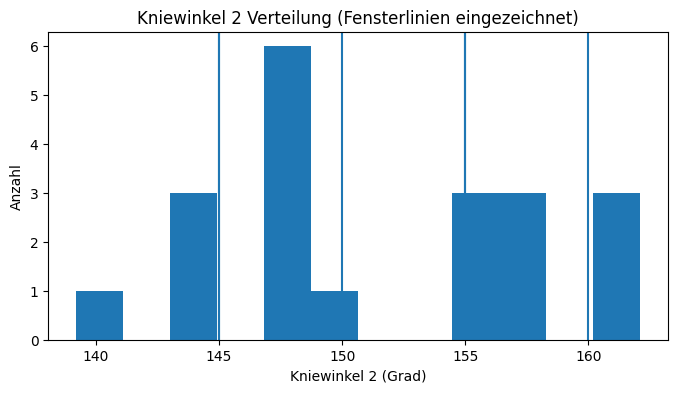

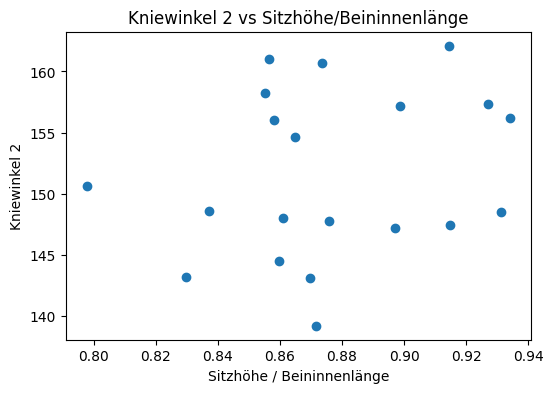

In [34]:
################
#   ZELLE 07   #
################


n = len(df)
print("n =", n)
print(df[["Kniewinkel 2", "AbsDev_Target"]].describe())

for key in WINDOWS:
    print(key, ":", int(df[f"In_{key}"].sum()), "/", n)

# Verteilung Kniewinkel 2 + Fenster
plt.figure(figsize=(8,4))
plt.hist(df["Kniewinkel 2"], bins=12)
for key,(lo,hi) in WINDOWS.items():
    plt.axvline(lo)
    plt.axvline(hi)
plt.title("Kniewinkel 2 Verteilung (Fensterlinien eingezeichnet)")
plt.xlabel("Kniewinkel 2 (Grad)")
plt.ylabel("Anzahl")
plt.show()

# Kniewinkel vs Sitzhoehe_rel (falls vorhanden)
if "Sitzhoehe_rel" in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df["Sitzhoehe_rel"], df["Kniewinkel 2"])
    plt.title("Kniewinkel 2 vs Sitzhöhe/Beininnenlänge")
    plt.xlabel("Sitzhöhe / Beininnenlänge")
    plt.ylabel("Kniewinkel 2")
    plt.show()


### Zelle 8 — Univariates Screening (robust): Variablen vs AbsDev_Target
**Zweck:** Findet Kandidatenfaktoren, die mit „näher am Optimum“ zusammenhängen — ohne zu overfitting.

**Was passiert:**
- Definiert Hilfsfunktionen:
  - `bootstrap_ci`: Bootstrap-Konfidenzintervalle (stabiler bei kleinem n).
  - `spearman_r`: Spearman-Korrelation (robust für ordinale/monotone Zusammenhänge).
- `screen_predictors` prüft jede numerische Variable:
  - Wenn binär (0/1): Effekt = Median(AbsDev | x=1) - Median(AbsDev | x=0)
    - **negativ** bedeutet: Gruppe mit x=1 ist im Median näher am Ziel.
    - CI per Bootstrap über Zeilenresampling.
  - Wenn kontinuierlich: Spearman r zwischen x und AbsDev + Bootstrap-CI.
- Schließt Outcomes/IDs aus (damit du nicht „gegen dich selbst“ korrelierst).
- Ergebnis ist eine Rangliste (`screen_absdev`) nach Stärke des Effekts.


In [35]:
################
#   ZELLE 08   #
################


def bootstrap_ci(values, stat_fn, n_boot=4000, seed=0):
    rng = np.random.default_rng(seed)
    vals = np.asarray(values)
    boots = []
    for _ in range(n_boot):
        samp = rng.choice(vals, size=len(vals), replace=True)
        boots.append(stat_fn(samp))
    boots = np.sort(boots)
    return float(boots[int(0.025*n_boot)]), float(boots[int(0.975*n_boot)])

def spearman_r(x, y):
    # Spearman über Ranks
    xr = pd.Series(x).rank().to_numpy()
    yr = pd.Series(y).rank().to_numpy()
    if np.std(xr) == 0 or np.std(yr) == 0:
        return np.nan
    return float(np.corrcoef(xr, yr)[0,1])

def screen_predictors(df, y_col, exclude_cols=None, min_group=3):
    if exclude_cols is None: exclude_cols = []
    y = df[y_col].astype(float).to_numpy()

    rows = []
    for c in df.columns:
        if c in exclude_cols or c == y_col:
            continue
        if c == "Proband Nr.":
            continue
        if c not in df.select_dtypes(include="number").columns:
            continue

        x = df[c].astype(float).to_numpy()
        uniq = np.unique(x[~np.isnan(x)])
        if len(uniq) <= 1:
            continue

        # binär?
        if set(uniq).issubset({0.0, 1.0}):
            g1 = y[x == 1]
            g0 = y[x == 0]
            if len(g1) < min_group or len(g0) < min_group:
                continue
            # Effekt: Median-Differenz (1 - 0); negativ = Gruppe(1) näher am Ziel (bei AbsDev)
            eff = float(np.median(g1) - np.median(g0))

            # Bootstrap CI über Resampling der gesamten Zeilen (robust)
            idx = np.arange(len(df))
            def stat_fn(sample_idx):
                sx = x[sample_idx]; sy = y[sample_idx]
                g1s = sy[sx == 1]; g0s = sy[sx == 0]
                if len(g1s)==0 or len(g0s)==0:
                    return np.nan
                return float(np.median(g1s) - np.median(g0s))
            ci_lo, ci_hi = bootstrap_ci(idx, stat_fn, n_boot=2500, seed=1)

            rows.append({"var": c, "type": "binary", "effect": eff, "ci_lo": ci_lo, "ci_hi": ci_hi,
                         "n1": int((x==1).sum()), "n0": int((x==0).sum())})

        else:
            # kontinuierlich -> Spearman
            r = spearman_r(x, y)

            idx = np.arange(len(df))
            def stat_fn(sample_idx):
                return spearman_r(x[sample_idx], y[sample_idx])
            ci_lo, ci_hi = bootstrap_ci(idx, stat_fn, n_boot=2500, seed=2)

            rows.append({"var": c, "type": "continuous", "effect": r, "ci_lo": ci_lo, "ci_hi": ci_hi,
                         "n1": np.nan, "n0": np.nan})

    out = pd.DataFrame(rows)
    out["abs_effect"] = out["effect"].abs()
    out = out.sort_values("abs_effect", ascending=False).reset_index(drop=True)
    return out

exclude = [
    "Kniewinkel 1", "Kniewinkel 2",
    "AbsDev_Target",
] + [f"In_{k}" for k in WINDOWS] + [f"WinDev_{k}" for k in WINDOWS] + [f"AbsWinDev_{k}" for k in WINDOWS]

screen_absdev = screen_predictors(df, "AbsDev_Target", exclude_cols=exclude)
screen_absdev.head(20)


var        type    effect  \
0                      Form der Fahrradnutzung_Beides      binary  3.950000   
1                Gefühl Sitzposition_Kein Unterschied      binary  3.500000   
2                               Methode bekannt_keine      binary  3.500000   
3                Gefühl Sitzposition_Etwas schlechter      binary -3.300000   
4                               Methode bekannt_Hüfte      binary -1.600000   
5                   Nutzung Methode_Augenmaß / Gefühl      binary  1.550000   
6                            Fahrradtyp_City/Commuter      binary  1.000000   
7            Form der Fahrradnutzung_Sport / Training      binary -0.800000   
8                                 Geschlecht_weiblich      binary  0.700000   
9                                 Geschlecht_männlich      binary -0.700000   
10                         Methode bekannt_Kniewinkel      binary  0.600000   
11  Form der Fahrradnutzung_Reines Fortbewegungsmi...      binary -0.600000   
12                            Dauer aktives Radfahren  continuous  0.470547   
13                              Fahrradtyp_Gravelbike      binary  0.450000   
14                      Nutzung Methode_Fersenmethode      binary  0.450000   
15                      Methode bekannt_Fersenmethode      binary  0.450000   
16  Form der Fahrradnutzung_Gelegentlich/Kein rege...      binary -0.400000   
17                             Fahrradtyp_Moutainbike      binary -0.400000   
18                                      km/Woche_Code  continuous  0.367923   
19  Methode bekannt_Formeln / Berechnung nach Bein...      binary  0.300000   

       ci_lo     ci_hi    n1    n0  abs_effect  
0  -0.200000  5.550000   6.0  14.0    3.950000  
1  -0.200000  5.100000   9.0  11.0    3.500000  
2   0.000000  4.800000   5.0  15.0    3.500000  
3  -4.600000  1.200000   9.0  11.0    3.300000  
4  -6.100000       NaN   3.0  17.0    1.600000  
5   0.600000  4.900000  16.0   4.0    1.550000  
6  -1.200000  4.800000  11.0   9.0    1.000000  
7  -4.500000       NaN   3.0  17.0    0.800000  
8  -3.900000  3.850000   6.0  14.0    0.700000  
9  -3.850000  3.950000  14.0   6.0    0.700000  
10 -3.300000  4.800000   7.0  13.0    0.600000  
11 -5.100000  1.750000   9.0  11.0    0.600000  
12  0.031976  0.775590   NaN   NaN    0.470547  
13 -3.700000  1.600000   4.0  16.0    0.450000  
14 -3.250000  5.700000   8.0  12.0    0.450000  
15 -3.250000  5.700000   8.0  12.0    0.450000  
16 -3.800000       NaN   3.0  17.0    0.400000  
17 -3.650000  4.500000   7.0  13.0    0.400000  
18 -0.060511  0.702744   NaN   NaN    0.367923  
19 -3.700000  4.600000   5.0  15.0    0.300000

### Zelle 9 — Top-Effekte visualisieren (Forest-Plot-ähnlich)
**Zweck:** Macht die wichtigsten Effekte aus Zelle 8 visuell und leicht interpretierbar.

**Was passiert:**
- Nimmt die Top-N Variablen aus `screen_absdev`.
- Plottet pro Variable:
  - Punkt = Effekt
  - Linie = Bootstrap-CI (Unsicherheit)
- Vertikale Linie bei 0: kein Effekt.
- Wichtig: Bei `AbsDev_Target` heißt **Effekt < 0** meist „besser/ näher am Ziel“.


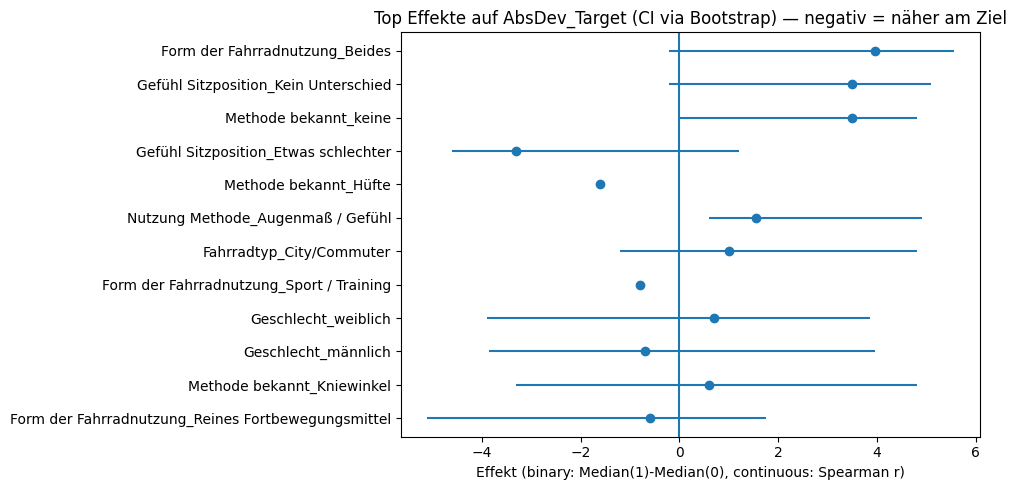

In [36]:
################
#   ZELLE 09   #
################


topn = 12
top = screen_absdev.head(topn).copy()

plt.figure(figsize=(10, 5))
ypos = np.arange(len(top))[::-1]
plt.hlines(y=ypos, xmin=top["ci_lo"], xmax=top["ci_hi"])
plt.plot(top["effect"], ypos, "o")
plt.yticks(ypos, top["var"])
plt.axvline(0)
plt.title("Top Effekte auf AbsDev_Target (CI via Bootstrap) — negativ = näher am Ziel")
plt.xlabel("Effekt (binary: Median(1)-Median(0), continuous: Spearman r)")
plt.tight_layout()
plt.show()


### Zelle 10 — Konfundierung raus: Residualisieren (Körpermaße/Sitzhöhe) + Screening
**Zweck:** Trennt „Biomechanik/Anthropometrie“ von „Umfragefaktoren“ (Methoden, Erfahrung, etc.).

**Was passiert:**
- Wählt Basisfeatures aus den vorhandenen Spalten: Sitzhöhe, Beininnenlänge, Größe, Alter (was da ist).
- Fit eines Ridge-Modells: `Kniewinkel2 ~ Basisfeatures`
  - Ridge stabilisiert bei kleinen Stichproben und korrelierten Inputs.
- Erstellt Residuen: `Knee2_resid = Kniewinkel2 - Vorhersage`
  - Residuen = das, was **nicht** durch Körpermaße/Sitzhöhe erklärt wird.
- Screeningt dann erneut wie in Zelle 8, aber jetzt mit `Knee2_resid` als Outcome,
  um Effekte zu finden, die über Anthropometrie hinausgehen.


In [37]:
################
#   ZELLE 10   #
################


# Basis-Modell: Kniewinkel 2 ~ (Sitzhöhe, Beininnenlänge, Größe, Alter) soweit vorhanden
base_feats = [c for c in ["Sitzhöhe", "Beininnenlänge", "Größe", "Alter"] if c in df.columns]
assert len(base_feats) >= 1, "Keine Basis-Features gefunden (Sitzhöhe/Beininnenlänge/Größe/Alter)."

X_base = df[base_feats].astype(float).to_numpy()
y_knee = df["Kniewinkel 2"].astype(float).to_numpy()

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 50), cv=LeaveOneOut()))
])
pipe.fit(X_base, y_knee)
y_pred = pipe.predict(X_base)
df["Knee2_resid"] = y_knee - y_pred

print("Basis-Features:", base_feats)
print("R2 (in-sample, nur zur Orientierung):", r2_score(y_knee, y_pred))

# Residuum als neues Outcome: was bleibt übrig, nachdem Körpermaße/Sitzhöhe erklärt sind?
exclude_resid = exclude + base_feats + ["Knee2_resid"]
screen_resid = screen_predictors(df, "Knee2_resid", exclude_cols=exclude_resid)
screen_resid.head(20)


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_re

Basis-Features: ['Sitzhöhe', 'Beininnenlänge', 'Größe', 'Alter']
R2 (in-sample, nur zur Orientierung): 0.5990471613148816


var        type    effect  \
0                               Fahrradtyp_Gravelbike      binary -5.857268   
1   Form der Fahrradnutzung_Gelegentlich/Kein rege...      binary  5.787831   
2                Gefühl Sitzposition_Etwas schlechter      binary -5.684997   
3   Methode bekannt_Formeln / Berechnung nach Bein...      binary -5.335594   
4                Gefühl Sitzposition_Kein Unterschied      binary  5.238015   
5            Form der Fahrradnutzung_Sport / Training      binary -5.048843   
6                          Methode bekannt_Kniewinkel      binary -3.877343   
7                       Nutzung Methode_Fersenmethode      binary -3.829283   
8                       Methode bekannt_Fersenmethode      binary -3.829283   
9                                 Geschlecht_männlich      binary  2.462619   
10                                Geschlecht_weiblich      binary -2.462619   
11                                 Fahrradtyp_Rennard      binary -2.399272   
12                              Methode bekannt_keine      binary  2.322973   
13                             Fahrradtyp_Moutainbike      binary  2.322973   
14                  Nutzung Methode_Augenmaß / Gefühl      binary -2.059022   
15                           Fahrradtyp_City/Commuter      binary -1.867148   
16                              Methode bekannt_Hüfte      binary  1.867148   
17                     Form der Fahrradnutzung_Beides      binary -1.442235   
18  Form der Fahrradnutzung_Reines Fortbewegungsmi...      binary -0.992874   
19                                 Häufigkeit / Woche  continuous -0.519465   

        ci_lo     ci_hi    n1    n0  abs_effect  
0  -10.404150 -1.256099   4.0  16.0    5.857268  
1    0.821033       NaN   3.0  17.0    5.787831  
2   -9.247575 -2.062482   9.0  11.0    5.684997  
3   -9.135785  3.520003   5.0  15.0    5.335594  
4   -0.754096  8.570725   9.0  11.0    5.238015  
5   -9.431999       NaN   3.0  17.0    5.048843  
6   -7.297610  4.941779   7.0  13.0    3.877343  
7   -8.484867  3.542643   8.0  12.0    3.829283  
8   -8.484867  3.542643   8.0  12.0    3.829283  
9   -5.787831  6.068278  14.0   6.0    2.462619  
10  -6.068278  5.787831   6.0  14.0    2.462619  
11  -9.363697  2.764147   4.0  16.0    2.399272  
12  -3.870442  7.332162   5.0  15.0    2.322973  
13  -5.191154  6.536128   7.0  13.0    2.322973  
14  -6.583213  8.323244  16.0   4.0    2.059022  
15  -5.684997  5.253489  11.0   9.0    1.867148  
16  -3.874863       NaN   3.0  17.0    1.867148  
17  -7.897344  6.101026   6.0  14.0    1.442235  
18  -5.684997  5.762496   9.0  11.0    0.992874  
19  -0.768393 -0.179391   NaN   NaN    0.519465

### Zelle 11 — Multivariat: Ridge-Modell für AbsDev_Target (LOOCV) + Koeffizienten
**Zweck:** Schaut, ob mehrere Faktoren *gemeinsam* AbsDev vorhersagen — und wie gut das generalisiert.

**Was passiert:**
- Baut Feature-Matrix X aus numerischen Spalten (ohne Outcomes/IDs).
- Nutzt Leave-One-Out Cross Validation (LOOCV):
  - Jede Person wird einmal „Test“, Rest „Train“ → gut bei kleinem n.
- `cross_val_predict` erzeugt LOOCV-Vorhersagen für jede Person.
- Bewertet Vorhersage:
  - `MAE`: mittlerer absoluter Fehler (in Grad)
  - `R²`: Anteil erklärter Varianz (kann bei kleinem n auch negativ sein)
- Fit auf allen Daten NUR, um Koeffizienten zu inspizieren:
  - große |coef| = Variable ist im multivariaten Modell wichtig (Interpretation vorsichtig!).


In [38]:
################
#   ZELLE 11   #
################


# Feature-Set: alles numerisch, aber ohne Outcomes/IDs
drop_cols = ["Proband Nr.", "Kniewinkel 1", "Kniewinkel 2", "AbsDev_Target", "Knee2_resid"] \
            + [f"In_{k}" for k in WINDOWS] + [f"WinDev_{k}" for k in WINDOWS] + [f"AbsWinDev_{k}" for k in WINDOWS]

feat_cols = [c for c in df.select_dtypes(include="number").columns if c not in drop_cols]
X = df[feat_cols].astype(float).to_numpy()
y = df["AbsDev_Target"].astype(float).to_numpy()

model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 60), cv=LeaveOneOut()))
])

# LOOCV Vorhersagen (ehrlicher als in-sample)
loo = LeaveOneOut()
y_hat = cross_val_predict(model, X, y, cv=loo)

print("LOOCV MAE:", mean_absolute_error(y, y_hat))
print("LOOCV R2 :", r2_score(y, y_hat))

# Fit auf allen Daten nur um Koeffizienten anzuschauen
model.fit(X, y)
coefs = model.named_steps["ridge"].coef_
coef_df = pd.DataFrame({"feature": feat_cols, "coef": coefs}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
coef_df.head(25)


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_re

LOOCV MAE: 2.5434613871621634
LOOCV R2 : -0.32821881847951184


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\metrics\_re

feature      coef
32                  Nutzung Methode_Augenmaß / Gefühl  0.982105
36                   Gefühl Sitzposition_Etwas besser -0.880791
19                                Fahrradtyp_Trecking -0.864779
0                                           Ben. Zeit  0.862808
7                             Dauer aktives Radfahren  0.858524
43                                     n_Methods_used  0.775117
15                              Fahrradtyp_Gravelbike -0.513580
25  Methode bekannt_Formeln / Berechnung nach Bein... -0.497201
22   Satteleinstellung, wer_Fahrradladen / Mechaniker -0.485280
11                     Form der Fahrradnutzung_Beides  0.450336
12  Form der Fahrradnutzung_Gelegentlich/Kein rege...  0.447106
8                                  Häufigkeit / Woche -0.430854
24                                 Dauer Satteleinst. -0.409225
9   Form der Fahrradnutzung_Reines Fortbewegungsmi... -0.397766
23                                    Zuverlässigkeit -0.396303
13                  Form der Fahrradnutzung_Sonstiges -0.394038
17                           Fahrradtyp_City/Commuter  0.332979
14                                 Fahrradtyp_Rennard -0.332600
10           Form der Fahrradnutzung_Sport / Training -0.313073
33                              Nutzung Methode_Hüfte -0.284993
37                Gefühl Sitzposition_Deutlich besser  0.255813
31                      Nutzung Methode_Fersenmethode  0.255525
26                      Methode bekannt_Fersenmethode  0.255525
28                              Methode bekannt_Hüfte -0.251577
4                                               Größe  0.225294

### Zelle 12 — Klassifikation „im Fenster“ (Standard: 145–155), LOOCV AUC/Accuracy
**Zweck:** Alternativer Blick: „im (realistischeren) Optimalfenster ja/nein“.

**Was passiert:**
- Nimmt als Ziel `In_w145_155` (meist besser balanciert als 150–155 bei dir).
- Trainiert eine L2-logistische Regression (stabil, wenig Overfitting).
- LOOCV liefert für jede Person eine vorhergesagte Wahrscheinlichkeit.
- Bewertet:
  - `AUC`: wie gut das Modell Rangordnung trennt (unabhängig vom Schwellenwert).
  - `Accuracy`: Trefferquote bei Schwelle 0.5 (bei Unbalance mit Vorsicht).
- Fit auf allen Daten, um Koeffizienten zu sehen:
  - Vorzeichen zeigt Richtung (mehr Wahrscheinlichkeit „im Fenster“).


In [39]:
################
#   ZELLE 12   #
################


# Hinweis: 150–155 ist bei dir extrem unausgewogen (nur 2/20). Daher als Standard: 145–155.
ybin = df["In_w145_155"].astype(int).to_numpy()

# LogReg mit L2 (stabil), LOOCV-Predictions
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(penalty="l2", C=1.0, solver="liblinear", max_iter=5000))
])

proba = cross_val_predict(clf, X, ybin, cv=loo, method="predict_proba")[:, 1]
pred  = (proba >= 0.5).astype(int)

print("Class balance (1=im Fenster):", int(ybin.sum()), "/", len(ybin))
print("LOOCV AUC     :", roc_auc_score(ybin, proba))
print("LOOCV Accuracy:", accuracy_score(ybin, pred))

# Fit auf allen Daten, um Koeffizienten zu sehen (Interpretation vorsichtig!)
clf.fit(X, ybin)
logreg = clf.named_steps["logreg"]
coef = logreg.coef_.ravel()
coef_df_bin = pd.DataFrame({"feature": feat_cols, "coef": coef}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
coef_df_bin.head(25)


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 an

Class balance (1=im Fenster): 8 / 20
LOOCV AUC     : 0.23958333333333331
LOOCV Accuracy: 0.25


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


feature      coef
36                   Gefühl Sitzposition_Etwas besser  0.697604
7                             Dauer aktives Radfahren -0.650836
13                  Form der Fahrradnutzung_Sonstiges  0.567922
32                  Nutzung Methode_Augenmaß / Gefühl -0.560746
0                                           Ben. Zeit -0.483454
19                                Fahrradtyp_Trecking  0.467762
20                                Fahrradtyp_Sonstige -0.430926
35               Gefühl Sitzposition_Kein Unterschied -0.401988
15                              Fahrradtyp_Gravelbike  0.390985
37                Gefühl Sitzposition_Deutlich besser -0.378433
21                  Satteleinstellung, wer_Ich selbst  0.365539
31                      Nutzung Methode_Fersenmethode  0.359436
26                      Methode bekannt_Fersenmethode  0.359436
11                     Form der Fahrradnutzung_Beides -0.344714
41                                      Sitzhoehe_rel -0.299543
25  Methode bekannt_Formeln / Berechnung nach Bein...  0.265810
10           Form der Fahrradnutzung_Sport / Training  0.262901
34               Gefühl Sitzposition_Etwas schlechter  0.262164
18                                  Fahrradtyp_E-Bike  0.233464
6                                            Sitzhöhe -0.229341
29                              Methode bekannt_keine -0.211669
42                                    n_Methods_known  0.211478
22   Satteleinstellung, wer_Fahrradladen / Mechaniker  0.203924
33                              Nutzung Methode_Hüfte  0.194556
30  Nutzung Methode_Formeln / Berechnung nach Bein... -0.191184

### Zelle 13 — Sensitivität: mehrere Fenster vergleichen
**Zweck:** Zeigt, ob deine Aussagen vom gewählten „optimal“-Fenster abhängen.

**Was passiert:**
- Wiederholt die Klassifikationsbewertung (AUC/Accuracy) für jedes Fenster.
- Wenn ein Fenster zu wenige 1er oder 0er hat (<5), wird es als „nicht sinnvoll“ markiert (NaN),
  weil die Bewertung dann extrem instabil wird.
- Ergebnis: Tabelle mit `window`, `n1`, `auc`, `acc`.


In [40]:
################
#   ZELLE 13   #
################


results = []
for key in WINDOWS.keys():
    ybin_k = df[f"In_{key}"].astype(int).to_numpy()
    # wenn zu wenige "1", macht Klassifikation wenig Sinn
    if ybin_k.sum() < 5 or (len(ybin_k) - ybin_k.sum()) < 5:
        results.append({"window": key, "n1": int(ybin_k.sum()), "auc": np.nan, "acc": np.nan})
        continue

    proba_k = cross_val_predict(clf, X, ybin_k, cv=loo, method="predict_proba")[:, 1]
    pred_k  = (proba_k >= 0.5).astype(int)
    results.append({
        "window": key,
        "n1": int(ybin_k.sum()),
        "auc": float(roc_auc_score(ybin_k, proba_k)),
        "acc": float(accuracy_score(ybin_k, pred_k))
    })

pd.DataFrame(results)


c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\mweiler\Documents\GitHub\MMI_Tool\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 an

window  n1       auc   acc
0  w150_155   2       NaN   NaN
1  w145_155   8  0.239583  0.25
2  w145_160  13  0.846154  0.80

### Zelle 14 — Export: Rankings + Koeffizienten speichern
**Zweck:** Macht deine Analyse reproducible: Ergebnisse liegen als CSV vor (für Bericht/Anhang).

**Was passiert:**
- Erstellt Ordner `results_out`.
- Speichert:
  - `screen_absdev.csv`: univariate Effekte auf AbsDev_Target
  - `screen_residual.csv`: univariate Effekte auf Residuen (nach Basis-Adjustierung)
  - `ridge_absdev_coefs.csv`: multivariate Ridge-Koeffizienten
  - `logreg_inwindow_coefs.csv`: logistische Koeffizienten
- Druckt den Speicherpfad.


In [41]:
################
#   ZELLE 14   #
################


out_dir = Path("results_out")
out_dir.mkdir(exist_ok=True)

screen_absdev.to_csv(out_dir / "screen_absdev.csv", index=False)
screen_resid.to_csv(out_dir / "screen_residual.csv", index=False)
coef_df.to_csv(out_dir / "ridge_absdev_coefs.csv", index=False)
coef_df_bin.to_csv(out_dir / "logreg_inwindow_coefs.csv", index=False)

print("Gespeichert in:", out_dir.resolve())



Gespeichert in: C:\Users\mweiler\Documents\GitHub\MMI_Tool\results_out
